**Step 1: Preprocessing and Data Loading**



In [212]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [213]:
from google.colab import files
uploaded = files.upload()

Saving dev.csv to dev (5).csv


In [214]:
data = pd.read_csv("dev.csv")



---



In [216]:
data.columns

Index(['Description', 'Commenting', 'Ogling/Facial Expressions/Staring',
       'Touching /Groping'],
      dtype='object')

In [217]:
# Display the first few rows of the dataset
print("Sample data:")
print(data.head())

Sample data:
                                         Description  Commenting  \
0  Buses approaching to this place is highly unsafe.           1   
1                        a man was commenting at me.           1   
2                                    in a share auto           0   
3  I was coming out of a club at night with a few...           1   
4  One of my friends was molested in the crowd. T...           0   

   Ogling/Facial Expressions/Staring  Touching /Groping  
0                                  0                  1  
1                                  0                  0  
2                                  0                  1  
3                                  0                  0  
4                                  0                  1  


Preprocessing text data

In [218]:
# Lowercase conversion
data['Description'] = data['Description'].str.lower()

In [219]:
# Tokenization and padding
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['Description'])
sequences = tokenizer.texts_to_sequences(data['Description'])
X_pad = pad_sequences(sequences, maxlen=maxlen)

In [220]:
# Vectorizing binary attributes (Commenting, Ogling/Facial Expressions/Staring)
y_binary = data[['Commenting', 'Ogling/Facial Expressions/Staring','Touching /Groping']]

In [221]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_pad, y_binary, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [222]:
# Display the shapes of the datasets
print("\nShapes of datasets:")
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Shapes of datasets:
Training set: (792, 100) (792, 3)
Validation set: (99, 100) (99, 3)
Test set: (99, 100) (99, 3)


**Step 2: Model Building**

In [223]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [224]:
# Define the model architecture
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

In [225]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [226]:
# Display the model summary
print("Model Summary:")
print(model.summary())

Model Summary:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 32)           320000    
                                                                 
 lstm_8 (LSTM)               (None, 64)                24832     
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 353539 (1.35 MB)
Trainable params: 353539 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Non

Hamming Score

In [227]:
# Importing necessary libraries
from sklearn.metrics import hamming_loss
import numpy as np

In [228]:
# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
25/25 [==============================] - 8s 153ms/step - loss: 0.6473 - accuracy: 0.6679 - val_loss: 0.6378 - val_accuracy: 0.7071
Epoch 2/10
25/25 [==============================] - 3s 134ms/step - loss: 0.6018 - accuracy: 0.7033 - val_loss: 0.6368 - val_accuracy: 0.7071
Epoch 3/10
25/25 [==============================] - 4s 147ms/step - loss: 0.5980 - accuracy: 0.7247 - val_loss: 0.6330 - val_accuracy: 0.7071
Epoch 4/10
25/25 [==============================] - 4s 159ms/step - loss: 0.5805 - accuracy: 0.7197 - val_loss: 0.6187 - val_accuracy: 0.7071
Epoch 5/10
25/25 [==============================] - 3s 134ms/step - loss: 0.5399 - accuracy: 0.7487 - val_loss: 0.6033 - val_accuracy: 0.7273
Epoch 6/10
25/25 [==============================] - 3s 134ms/step - loss: 0.4812 - accuracy: 0.7500 - val_loss: 0.5981 - val_accuracy: 0.6364
Epoch 7/10
25/25 [==============================] - 4s 178ms/step - loss: 0.3970 - accuracy: 0.7753 - val_loss: 0.6813 - val_accuracy: 0.6263
Epoch 

In [229]:
# After training, predict on the validation set
y_val_pred = model.predict(X_val)

4/4 [==============================] - 0s 16ms/step


In [230]:
print("Shape of y_val:", y_val.shape)
print("Shape of y_val_pred:", y_val_pred.shape)

Shape of y_val: (99, 3)
Shape of y_val_pred: (99, 3)


In [231]:
if y_val.shape[0] != y_val_pred.shape[0]:
    raise ValueError("y_val and y_val_pred must have the same number of rows.")

In [232]:
# Ensure shapes are compatible
y_val_pred = y_val_pred[:y_val.shape[0]]

In [233]:
# Calculate Hamming score
hamming_score = 1 - hamming_loss(y_val, (y_val_pred > 0.5).astype(int))
print("Hamming Score on Validation Set:", hamming_score)

Hamming Score on Validation Set: 0.7070707070707071


**Step 3: Explainable AI Integration with LIME**

In [234]:
# Importing necessary libraries
import lime
import lime.lime_tabular

In [235]:
# Create an explainer object for the trained model
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification')

In [236]:
# Generate LIME explanations for the validation set
instance_idx = 0
instance = X_val[instance_idx]
explanation = explainer.explain_instance(instance, model.predict, num_features=len(X_val[0]))


157/157 [==============================] - 3s 18ms/step


/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


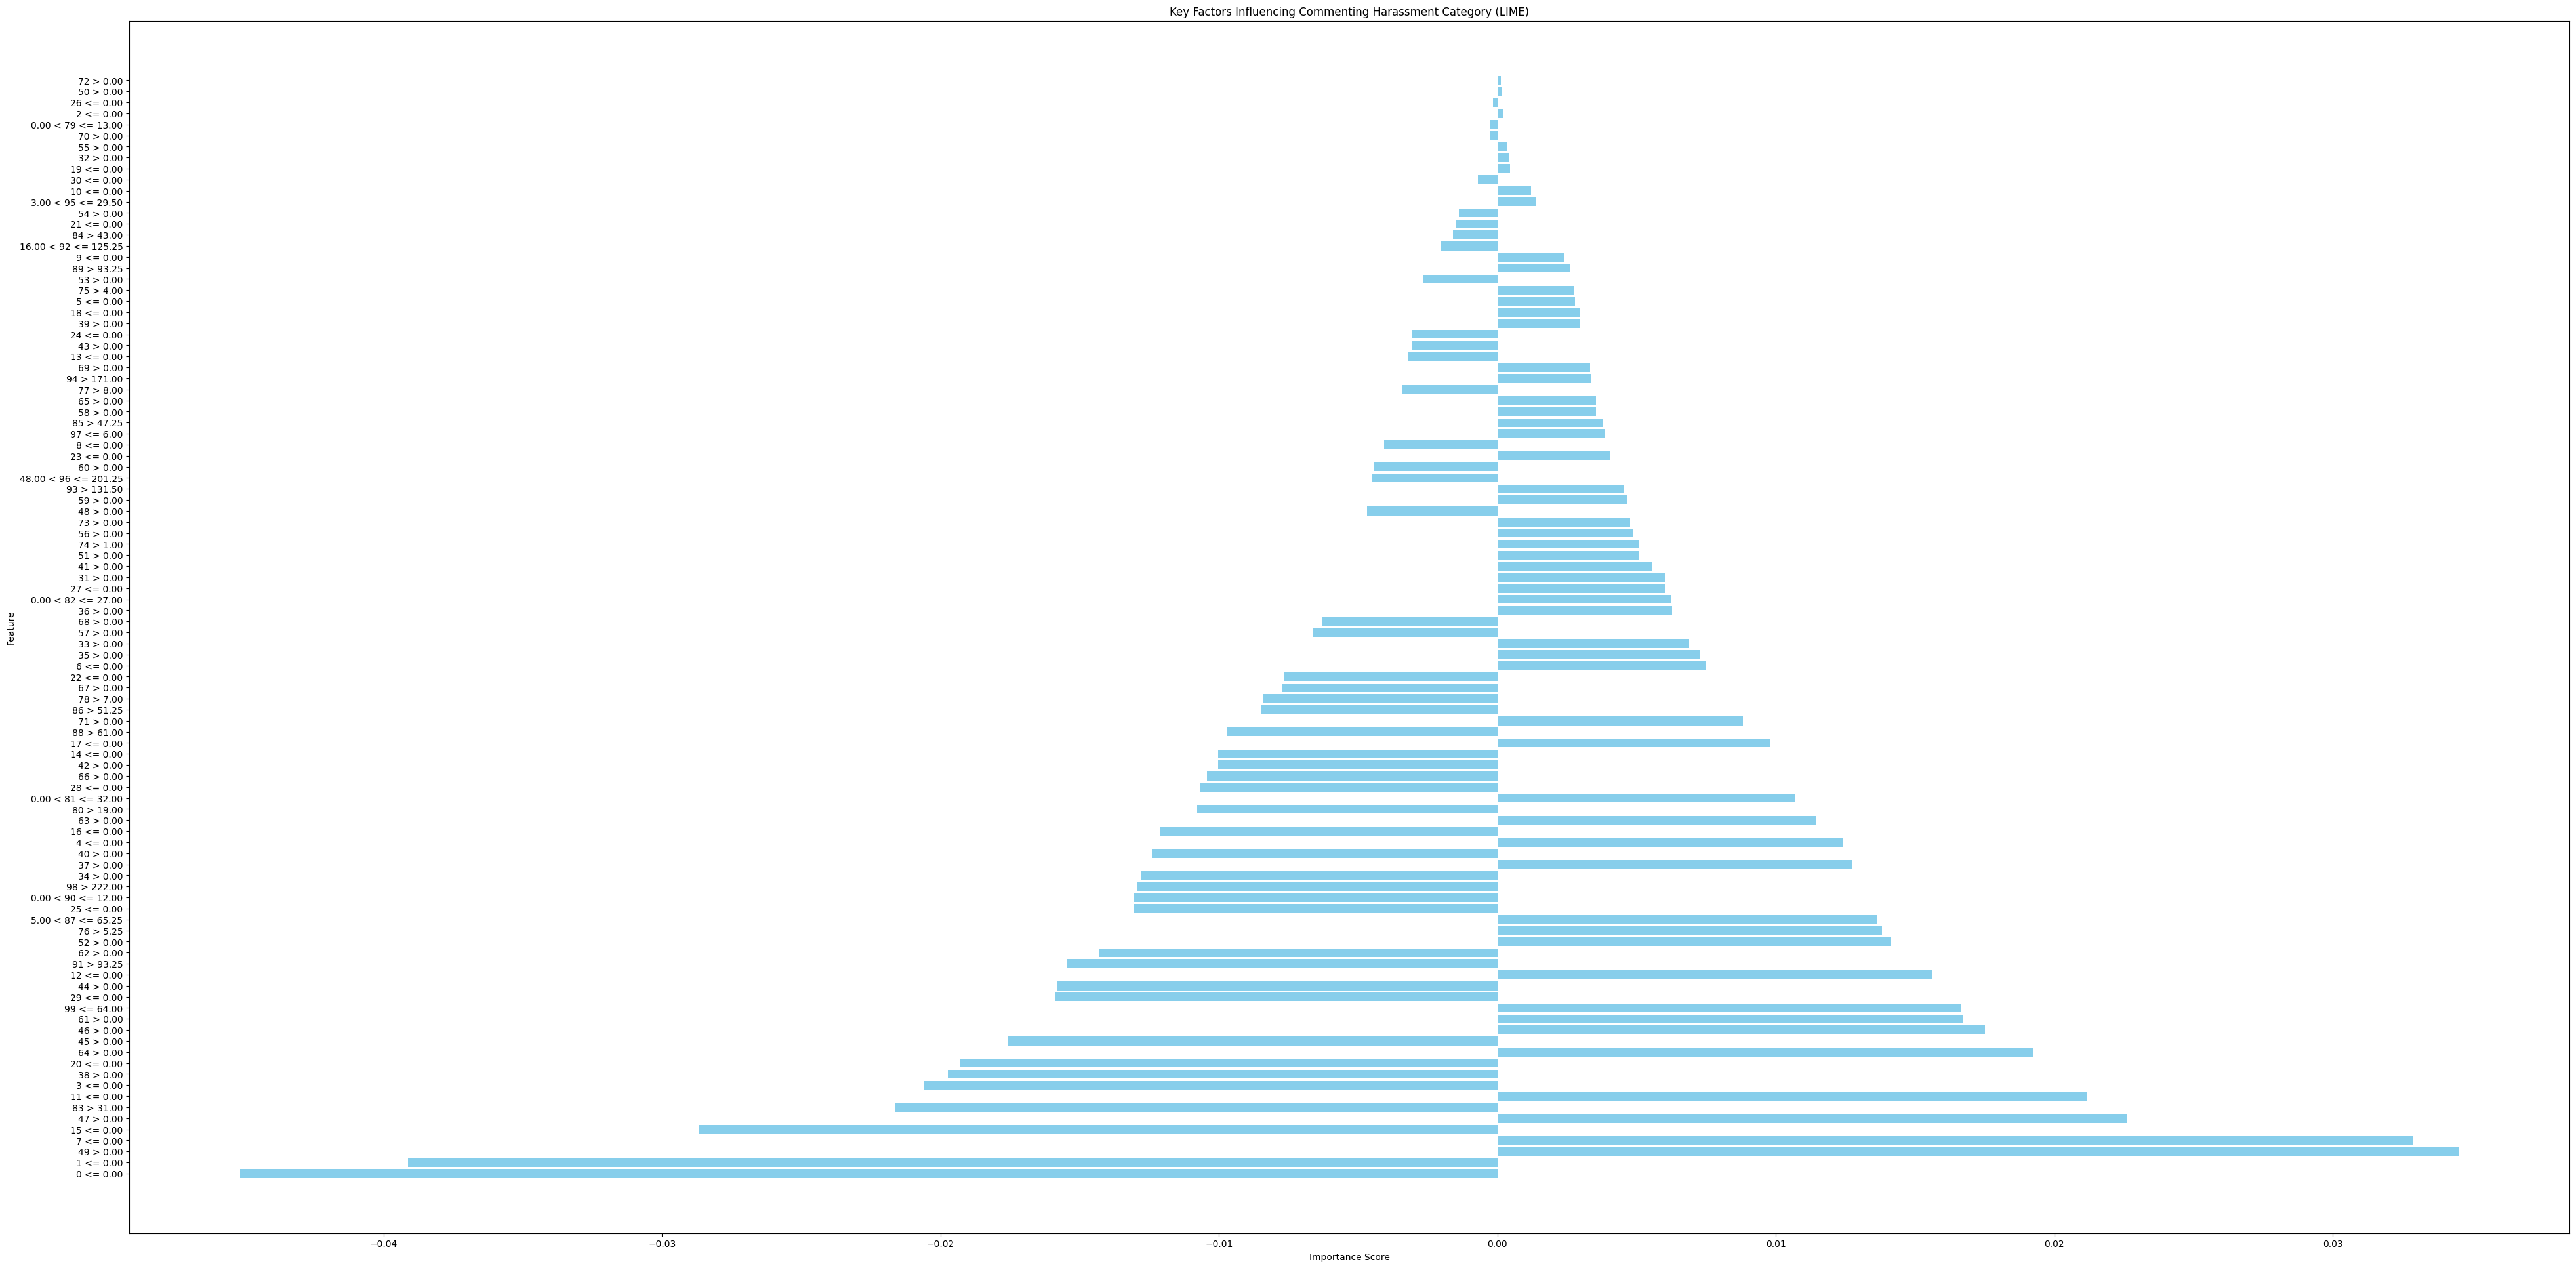

In [237]:
import matplotlib.pyplot as plt

# Extract LIME explanation for a specific instance and category (e.g., instance_idx and category_idx)
instance_idx = 0  # Index of the instance in the validation set
category_idx = 0  # Index of the harassment category

# Extract LIME explanation for the selected instance and category
label_idx = 1  # Assuming binary classification, where the label index is either 0 or 1
lime_explanation = explanation.as_list(label=label_idx)

# Extract feature names (words or phrases) and their corresponding importance scores
features = [feature[0] for feature in lime_explanation]
importance_scores = [feature[1] for feature in lime_explanation]

# Create a bar plot to visualize the important features and their importance scores
plt.figure(figsize=(48, 24))
plt.barh(range(len(features)), importance_scores, color='skyblue')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Key Factors Influencing Commenting Harassment Category (LIME)')
plt.show()


In [238]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


In [239]:
# Splitting data into features and labels
X = data['Description']
y_commenting = data['Commenting']
y_ogling = data['Ogling/Facial Expressions/Staring']
y_touching = data['Touching /Groping']

In [240]:
# Train-test split for commenting
X_train_cmt, X_test_cmt, y_train_cmt, y_test_cmt = train_test_split(X, y_commenting, test_size=0.2, random_state=42)

# Train-test split for ogling
X_train_ogl, X_test_ogl, y_train_ogl, y_test_ogl = train_test_split(X, y_ogling, test_size=0.2, random_state=42)

# Train-test split for touching
X_train_tch, X_test_tch, y_train_tch, y_test_tch = train_test_split(X, y_touching, test_size=0.2, random_state=42)

In [241]:
# Define the classifiers
classifier_cmt = make_pipeline(
    TfidfVectorizer(),
    SVC(probability=True)
)

classifier_ogl = make_pipeline(
    TfidfVectorizer(),
    SVC(probability=True)
)

classifier_tch = make_pipeline(
    TfidfVectorizer(),
    SVC(probability=True)
)

In [242]:
# Train the classifiers
classifier_cmt.fit(X_train_cmt, y_train_cmt)
classifier_ogl.fit(X_train_ogl, y_train_ogl)
classifier_tch.fit(X_train_tch, y_train_tch)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(probability=True))])

In [243]:
# Predict probabilities and delete descriptions with probability less than 0.7
def process_and_delete(classifier, X_test, y_test):
    probabilities = classifier.predict_proba(X_test)
    for i, prob in enumerate(probabilities):
        if max(prob) < 0.7:
            print("Deleting description:", X_test.iloc[i])
            X_test.iloc[i] = ""
    return X_test

In [245]:
# Performance evaluation
print("Classification report for commenting:")
print(classification_report(y_test_cmt, classifier_cmt.predict(X_test_cmt_processed)))
print("\nClassification report for ogling:")
print(classification_report(y_test_ogl, classifier_ogl.predict(X_test_ogl_processed)))
print("\nClassification report for touching:")
print(classification_report(y_test_tch, classifier_tch.predict(X_test_tch_processed)))

Classification report for commenting:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80       116
           1       0.93      0.33      0.49        82

    accuracy                           0.71       198
   macro avg       0.80      0.66      0.64       198
weighted avg       0.78      0.71      0.67       198


Classification report for ogling:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       147
           1       1.00      0.10      0.18        51

    accuracy                           0.77       198
   macro avg       0.88      0.55      0.52       198
weighted avg       0.82      0.77      0.69       198


Classification report for touching:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       140
           1       0.77      0.29      0.42        58

    accuracy                           0.77       198
   macro avg      

In [287]:
# Function to predict and delete sexually harassing descriptions
def process_and_delete(classifier, description):
    prob = classifier.predict_proba([description])[0]
    if max(prob) < 0.85:
        print("The description is not sexually harassing.")
    else:
        print("The description is sexually harassing and has been taken action by a government.")
        return ""

In [272]:
# Input 5 descriptions
for i in range(5):
    description = input("Enter description {}: ".format(i+1))
    print("\nPredictions:")
    print("Commenting:", end=" ")
    process_and_delete(classifier_cmt, description)
    print("Ogling:", end=" ")
    process_and_delete(classifier_ogl, description)
    print("Touching/Groping:", end=" ")
    process_and_delete(classifier_tch, description)
    print("\n")

Enter description 1: i drink coffee

Predictions:
Commenting: The description is not sexually harassing.
Ogling: The description is not sexually harassing.
Touching/Groping: The description is not sexually harassing.


Enter description 2: i like flowes

Predictions:
Commenting: The description is not sexually harassing.
Ogling: The description is not sexually harassing.
Touching/Groping: The description is not sexually harassing.


Enter description 3: i love music

Predictions:
Commenting: The description is not sexually harassing.
Ogling: The description is not sexually harassing.
Touching/Groping: The description is not sexually harassing.


Enter description 4: i wanna fuck you

Predictions:
Commenting: The description is not sexually harassing.
Ogling: The description is not sexually harassing.
Touching/Groping: The description is sexually harassing and has been taken action by a government.


Enter description 5: Received an unwelcome comment about my looks from a colleague.

Pr

In [290]:
from IPython.display import display
import ipywidgets as widgets

# Define text input widget
description_input = widgets.Text(placeholder='Enter description')

# Define output widget
output = widgets.Output()

# Define function to handle button click
def handle_submit(sender):
    with output:
        output.clear_output()
        description = description_input.value
        print("\nPredictions:")
        print("Commenting:", end=" ")
        if process_and_delete(classifier_cmt, description):
            # Take action to delete the comment here
            pass
        print("Ogling:", end=" ")
        if process_and_delete(classifier_ogl, description):
            # Take action to delete the comment here
            pass
        print("Touching/Groping:", end=" ")
        if process_and_delete(classifier_tch, description):
            # Take action to delete the comment here
            pass

# Define button
submit_button = widgets.Button(description='Submit')

# Assign function to button click event
submit_button.on_click(handle_submit)

# Display widgets
display(description_input)
display(submit_button)
display(output)

Text(value='', placeholder='Enter description')

Button(description='Submit', style=ButtonStyle())

Output()